## Урок 4. Кейс 1. Построение и оценка модели

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

In [2]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [3]:
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

#### 1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

In [6]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [7]:
w_data = data.resample('W').mean()
w_data.drop(columns=['dayofmonth', 'dayofyear', 'dayofweek', 'hour', 'is_holiday', 'is_prev_holiday', 'is_next_holiday'], 
            axis=1, inplace=True)
w_data.head()

,PJME_MW,year,month,quarter,weekofyear
Date,,,,,
2002-01-06,32392.160839,2002.0,1.000000,1.0,1.0
2002-01-13,31487.386905,2002.0,1.000000,1.0,2.0
2002-01-20,31452.880952,2002.0,1.000000,1.0,3.0
2002-01-27,30141.529762,2002.0,1.000000,1.0,4.0
2002-02-03,29196.488095,2002.0,1.428571,1.0,5.0


#### 2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .

Добавим новых признаков, описывающих содержание ряда. К таким признакам можно отнести разности ряда и разнообразные варианты сглаживания.

In [8]:
first_diff = np.array(w_data.iloc[1:,0].values - w_data.iloc[:-1,0].values).astype('float32') 
w_data['diff1'] = 0
w_data['diff1'] = w_data['diff1'].astype('float') 
w_data['diff1'].values[1:] = first_diff

In [9]:
first_diff_d = (first_diff) / w_data.iloc[1:,0].values
w_data['diff1_d'] = 0
w_data['diff1_d'] = w_data['diff1_d'].astype('float') 
w_data['diff1_d'].values[1:] = np.array(first_diff_d).astype('float32')

In [10]:
first_diff_l = np.log(w_data.iloc[1:,0].values) 
w_data['diff1_l'] = 0
w_data['diff1_l'] = w_data['diff1_l'].astype('float') 
w_data['diff1_l'].values[1:] = first_diff_l

In [11]:
w_data['d_w4'] = w_data['PJME_MW'].rolling(window=4).mean()

In [12]:
w_data['exp_0_05'] = exponential_smoothing(w_data['PJME_MW'], 0.05)

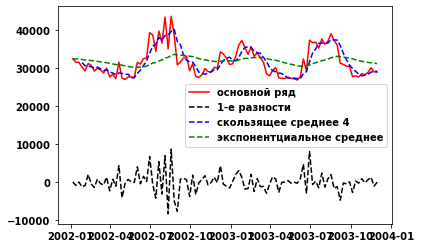

In [13]:
N100=100
plt.plot(w_data.index[:N100], w_data['PJME_MW'][:N100],'r',label ='основной ряд')
plt.plot(w_data.index[:N100], w_data['diff1'][:N100],'--k',label ='1-е разности')
plt.plot(w_data.index[:N100], w_data['d_w4'][:N100],'--b',label ='скользящее среднее 4')
plt.plot(w_data.index[:N100], w_data['exp_0_05'][:N100],'--g',label ='экспонентциальное среднее')
plt.legend()
plt.show()

Добавим ещё экспоненциальные средние

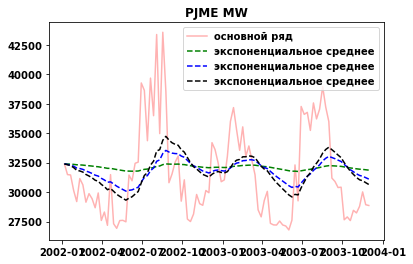

In [14]:
w_data['exp_0_01'] = exponential_smoothing(w_data['PJME_MW'], 0.01)
w_data['exp_0_03'] = exponential_smoothing(w_data['PJME_MW'], 0.03)
w_data['exp_0_04'] = exponential_smoothing(w_data['PJME_MW'], 0.04)
w_data['exp_0_06'] = exponential_smoothing(w_data['PJME_MW'], 0.06)
w_data['exp_0_07'] = exponential_smoothing(w_data['PJME_MW'], 0.07)
w_data['exp_0_08'] = exponential_smoothing(w_data['PJME_MW'], 0.08)

N100=100
plt.plot(w_data.index[:N100],w_data['PJME_MW'][:N100],'r',label ='основной ряд',alpha=0.3)
plt.plot(w_data.index[:N100],w_data['exp_0_01'][:N100],'--g',label ='экспоненциальное среднее')
plt.plot(w_data.index[:N100],w_data['exp_0_05'][:N100],'--b',label ='экспоненциальное среднее')
plt.plot(w_data.index[:N100],w_data['exp_0_08'][:N100],'--k',label ='экспоненциальное среднее')
plt.legend()
plt.title('PJME MW')
plt.show()

Добавим истории длиной p в признаках автокорреляции

In [15]:
p = 4
for i in range(p):
    w_data['t'+str(p-i)]=0
    w_data['t'+str(p-i)].values[p:] = w_data['PJME_MW'].values[i:-(p)+i]

Аналогично добавляем первые разности на глубину p

In [16]:
# p = 4
for i in range(p):
    w_data['d'+str(p-i)]=0
    w_data['d'+str(p-i)].values[p:] = w_data['diff1'].values[i:-(p)+i]

В итоге данные примут вид

In [17]:
w_data

,PJME_MW,year,month,quarter,weekofyear,diff1,diff1_d,diff1_l,d_w4,exp_0_05,...,exp_0_07,exp_0_08,t4,t3,t2,t1,d4,d3,d2,d1
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,1.0,1.0,0.000000,0.000000,0.000000,NaN,32392.160839,...,32392.160839,32392.160839,0,0,0,0,0,0,0,0
2002-01-13,31487.386905,2002.0,1.000000,1.0,2.0,-904.773926,-0.028734,10.357342,NaN,32346.922142,...,32328.826664,32319.778924,0,0,0,0,0,0,0,0
2002-01-20,31452.880952,2002.0,1.000000,1.0,3.0,-34.505951,-0.001097,10.356246,NaN,32302.220083,...,32267.510464,32250.427087,0,0,0,0,0,0,0,0
2002-01-27,30141.529762,2002.0,1.000000,1.0,4.0,-1311.351196,-0.043506,10.313659,31368.489615,32194.185567,...,32118.691815,32081.715301,0,0,0,0,0,0,0,0
2002-02-03,29196.488095,2002.0,1.428571,1.0,5.0,-945.041687,-0.032368,10.281804,30569.571429,32044.300693,...,31914.137554,31850.897124,32392,31487,31452,30141,0,-904,-34,-1311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-08,38459.982143,2018.0,7.000000,3.0,27.0,2548.142822,0.066254,10.557374,34850.102679,31029.513277,...,31145.037913,31223.895665,28615,30316,34711,35911,-2330,1701,4394,1200
2018-07-15,36420.035714,2018.0,7.000000,3.0,28.0,-2039.946411,-0.056012,10.502874,36375.876488,31299.039399,...,31514.287759,31639.586869,30316,34711,35911,38459,1701,4394,1200,2548
2018-07-22,35612.095238,2018.0,7.000000,3.0,29.0,-807.940491,-0.022687,10.480441,36600.988095,31514.692191,...,31801.134283,31957.387539,34711,35911,38459,36420,4394,1200,2548,-2039


Горизонт прогнозирования h = 4

Масштабирование

In [18]:
scl_target_4 = StandardScaler() 
# p = 4
h = 4
target_4 = w_data['PJME_MW'].values[h+p:].reshape((w_data.shape[0]-h-p,1))
y = scl_target_4.fit_transform(target_4)
y.shape

(858, 1)

In [19]:
scl_x_4 = StandardScaler()
X = w_data.iloc[p:-h,:].values
X = scl_x_4.fit_transform(X.astype('float64'))
X.shape

(858, 24)

Разделение данных на тестовые и тренировочные<br>
Для временного ряда "Потребление энергии" назначим датой разделения 1/06/2016

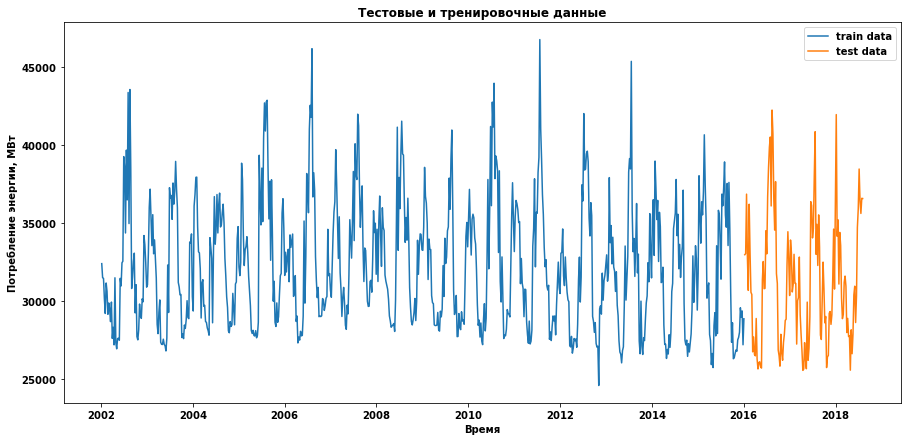

In [20]:
train_4, test_4 = split_data(w_data, '01-06-2016')
X_train_4 = X[:train_4.shape[0],:]
y_train_4 = y[:train_4.shape[0],0]
X_test_4 = X[train_4.shape[0]:,:]
y_test_4 = y[train_4.shape[0]:,0]

plt.figure(figsize=(15, 7))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train_4.index.get_level_values('Date'),train_4['PJME_MW'], label='train data')
plt.plot(test_4.index.get_level_values('Date'),test_4['PJME_MW'], label='test data')
plt.title('Тестовые и тренировочные данные')
plt.legend()
plt.show()

Строим Модель

In [21]:
# Выделяем 5 важных признаков
gr_model = GradientBoostingRegressor(max_depth=2, n_estimators=100, random_state=0).fit(X_train_4, y_train_4)
sfm = SelectFromModel(gr_model, max_features = 5)
sfm.fit(X_train_4, y_train_4)
X_train_4 = sfm.transform(X_train_4)
X_test_4 = sfm.transform(X_test_4)

print(w_data.columns[sfm.get_support()])

Index(['PJME_MW', 'month', 'weekofyear', 'diff1_l', 't4'], dtype='object')


In [22]:
# Подбираем параметры
param_dist = {"max_depth": [1,2,3,4,5], 
              "n_estimators": [100,200,300,400,500]}
n_iter_search = 10
model_gr = GradientBoostingRegressor()
random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False, 
                                   random_state=0)
random_search.fit(X_train_4, y_train_4)
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.648 (std: 0.056)
Parameters: {'n_estimators': 100, 'max_depth': 2}

Model with rank: 2
Mean validation score: 0.639 (std: 0.064)
Parameters: {'n_estimators': 300, 'max_depth': 1}

Model with rank: 3
Mean validation score: 0.629 (std: 0.066)
Parameters: {'n_estimators': 200, 'max_depth': 3}



In [23]:
# Итоговая модель
model_g_4 = GradientBoostingRegressor(max_depth=2, n_estimators=100, random_state=0)
model_g_4.fit(X_train_4, y_train_4)
y_test_pred_g = model_g_4.predict(X_test_4)

er_g = mean_absolute_percentage_error(y_true=scl_target_4.inverse_transform(y_test_4),
                                      y_pred=scl_target_4.inverse_transform(y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   7.150045085306744 %


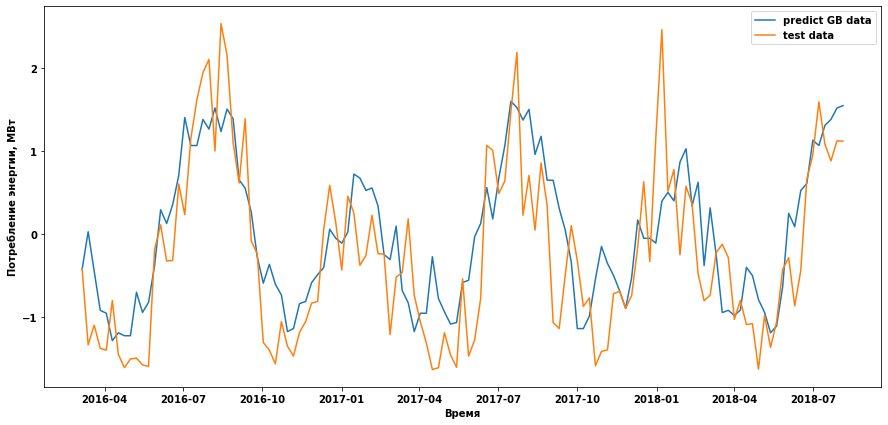

In [24]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test_4.index[h+p:],y_test_pred_g, label='predict GB data' )
plt.plot(test_4.index[h+p:],y_test_4, label='test data')
plt.legend()
plt.show()

#### 3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.

Горизонт прогнозирования h = 1

Масштабирование

In [25]:
scl_target_1 = StandardScaler() 
p = 4
h = 1
target_1 = w_data['PJME_MW'].values[h+p:].reshape((w_data.shape[0]-h-p,1))
y = scl_target_1.fit_transform(target_1)
y.shape

(861, 1)

In [26]:
scl_x_1 = StandardScaler() 

X = w_data.iloc[p:-h,:].values
X = scl_x_1.fit_transform(X.astype('float64'))
X.shape

(861, 24)

Разделение данных на тестовые и тренировочные<br>
Для временного ряда "Потребление энергии" назначим датой разделения 1/06/2016

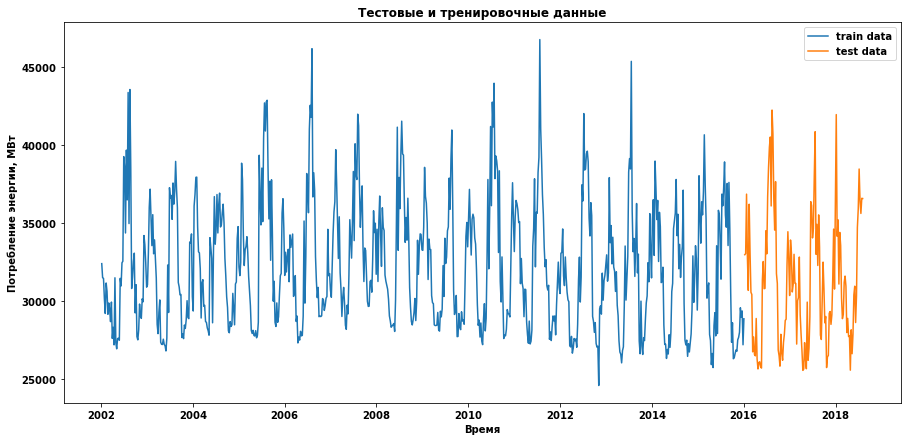

In [27]:
train_1, test_1 = split_data(w_data, '01-06-2016')
X_train_1 = X[:train_1.shape[0],:]
y_train_1 = y[:train_1.shape[0],0]
X_test_1 = X[train_1.shape[0]:,:]
y_test_1 = y[train_1.shape[0]:,0]

plt.figure(figsize=(15, 7))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train_1.index.get_level_values('Date'),train_1['PJME_MW'], label='train data')
plt.plot(test_1.index.get_level_values('Date'),test_1['PJME_MW'], label='test data')
plt.title('Тестовые и тренировочные данные')
plt.legend()
plt.show()

Строим Модель

In [28]:
# Выделяем 5 важных признаков
gr_model = GradientBoostingRegressor(max_depth=2, n_estimators=100, random_state=0).fit(X_train_1, y_train_1)
sfm = SelectFromModel(gr_model, max_features = 5)
sfm.fit(X_train_1, y_train_1)
X_train_1 = sfm.transform(X_train_1)
X_test_1 = sfm.transform(X_test_1)

print(w_data.columns[sfm.get_support()])

Index(['PJME_MW', 'month', 'weekofyear', 'diff1_l', 't1'], dtype='object')


In [29]:
# Подбираем параметры
param_dist = {"max_depth": [1,2,3,4,5], 
              "n_estimators": [100,200,300,400,500]}
n_iter_search = 10
model_gr = GradientBoostingRegressor()
random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False,
                                   random_state=0)
random_search.fit(X_train_1, y_train_1)
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.700 (std: 0.051)
Parameters: {'n_estimators': 100, 'max_depth': 2}

Model with rank: 2
Mean validation score: 0.694 (std: 0.047)
Parameters: {'n_estimators': 300, 'max_depth': 1}

Model with rank: 3
Mean validation score: 0.675 (std: 0.043)
Parameters: {'n_estimators': 200, 'max_depth': 3}



In [30]:
# Итоговая модель
model_g_1 = GradientBoostingRegressor(max_depth=2, n_estimators=100, random_state=0)
model_g_1.fit(X_train_1, y_train_1)
y_test_pred_g = model_g_1.predict(X_test_1)

er_g = mean_absolute_percentage_error(y_true=scl_target_1.inverse_transform(y_test_1),
                                      y_pred=scl_target_1.inverse_transform(y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   6.176122019799803 %


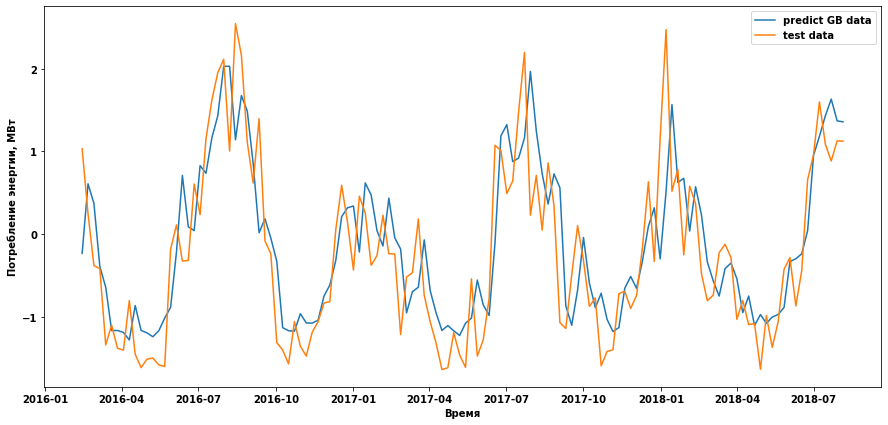

In [31]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test_1.index[h+p:],y_test_pred_g, label='predict GB data' )
plt.plot(test_1.index[h+p:],y_test_1, label='test data')
plt.legend()
plt.show()

#### 4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.

In [32]:
point = 4

In [33]:
# Прямое моделирование
y_test_pred_g_4 = model_g_4.predict([X_test_4[0,]])
# Ошибка
er_g = mean_absolute_percentage_error(y_true=scl_target_4.inverse_transform([y_test_4[0]]),
                                      y_pred=scl_target_4.inverse_transform(y_test_pred_g_4))
print('Прямое моделирование, ошибка градиентного бустинга MAPE :  ', er_g,'%')

Прямое моделирование, ошибка градиентного бустинга MAPE :   0.11282253733715902 %


Рекурсивное моделирование, ошибка градиентного бустинга MAPE :   4.751652773052969 %


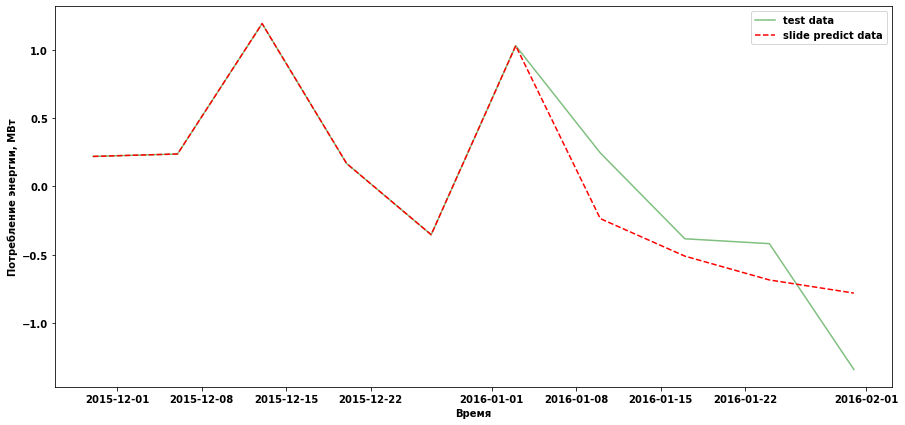

In [34]:
# Рекурсивное моделирование
# Поля: 'PJME_MW', 'month', 'weekofyear', 'diff1_l', 't1'
# Чтобы вычислить поле t1 нужны предыдущие данные, поэтому добавим к тестовым данным, данные из обучения.
# А из тестовых данных возьмём только первую точку, относительно которой будем вычислять 4-ю точку.
X_test_100 = np.vstack((X_train_1.copy(), X_test_1[0]))
y_test_100 = np.hstack((y_train_1.copy(), y_test_1[0]))
N = point

for i in range(N):
    # По последней известной строке предсказываем следующую и добавляем результат в y_test_100
    y_test_100 = np.hstack([y_test_100, model_g_1.predict(X_test_100[-1,:].reshape((1,5)))])
    # Вычисленное значение таргета надо сначало восстановить из масштабирования по таргету и затем отмасштабировать по X
    real_target = scl_target_1.inverse_transform([y_test_100[-1]])
    scl_target = scl_x_1.transform([np.concatenate((real_target, [0]*23), axis=0)])[0][0]
    # Заполняем вектор для прогноза следующей точки
    # Из тестовых данных возьм только поля month и weekofyear, остальные заполним вручную
    X_test_100 = np.vstack([X_test_100, X_test_1[i+1]])
    # PJME_MW
    X_test_100[-1, 0] = scl_target
    # diff1_l
    # Для вычисления логарифма нужно использовать восстановленное значение таргета из масштабирования по таргету
    X_test_100[-1, 3] = scl_x_1.transform([np.concatenate((np.log(real_target), [0]*23), axis=0)])[0][0]
    # t1
    X_test_100[-1, 4] = X_test_100[-1, 0] 

# Ошибка
er_g = mean_absolute_percentage_error(y_true=scl_target_1.inverse_transform([y_test_1[point-1]]),
                                      y_pred=scl_target_1.inverse_transform([y_test_100[-1]]))
print('Рекурсивное моделирование, ошибка градиентного бустинга MAPE :  ', er_g,'%')

# Нарисуем на графике 5 точек из train и 5 точек из test
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
x_ax = np.concatenate((train_1.index, test_1.index[0:point]), axis=0)
plt.plot(x_ax[-(5+point+1):], np.concatenate((y_train_1[-5:], y_test_1[0:point+1]), axis=0), 'g',label='test data', alpha=0.5)
plt.plot(x_ax[-(5+point+1):], y_test_100[-(5+point+1):], '--r',label='slide predict data')
plt.legend()
plt.show() 

При рекурсивном моделировании ошибка в точке 4 получилась больше чем при прямом моделировании. Это связано с накоплением ошибки в процессе вычисления предыдущих точек.

#### 5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреднение по десяткам точек)

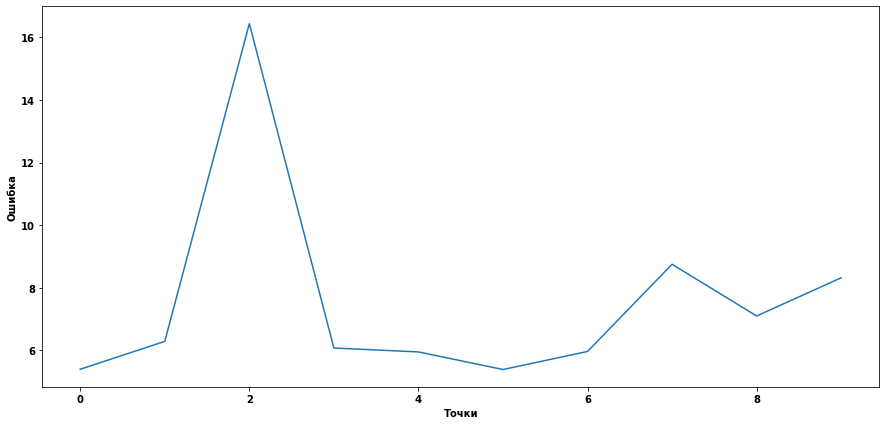

In [37]:
# Поля: 'PJME_MW', 'month', 'weekofyear', 'diff1_l', 't1'
# Чтобы вычислить поле t1 нужны предыдущие данные, поэтому добавим к тестовым данным, данные из обучения.
# А из тестовых данных возьмём только первую точку, относительно которой будем вычислять 4-ю точку.
X_test_100 = np.vstack((X_train_1.copy(), X_test_1[0]))
y_test_100 = np.hstack((y_train_1.copy(), y_test_1[0]))
N = 100
err = []
err_mean = []

for i in range(N):
    # По последней известной строке предсказываем следующую и добавляем результат в y_test_100
    y_test_100 = np.hstack([y_test_100, model_g_1.predict(X_test_100[-1,:].reshape((1,5)))])
    # Вычисленное значение таргета надо сначало восстановить из масштабирования по таргету и затем отмасштабировать по X
    real_target = scl_target_1.inverse_transform([y_test_100[-1]])
    scl_target = scl_x_1.transform([np.concatenate((real_target, [0]*23), axis=0)])[0][0]
    # Заполняем вектор для прогноза следующей точки
    # Из тестовых данных возьм только поля month и weekofyear, остальные заполним вручную
    X_test_100 = np.vstack([X_test_100, X_test_1[i+1]])
    # PJME_MW
    X_test_100[-1, 0] = scl_target
    # diff1_l
    # Для вычисления логарифма нужно использовать восстановленное значение таргета из масштабирования по таргету
    X_test_100[-1, 3] = scl_x_1.transform([np.concatenate((np.log(real_target), [0]*23), axis=0)])[0][0]
    # t1
    X_test_100[-1, 4] = X_test_100[-1, 0] 

    # Ошибка
    if (i > 0) and (i % 10 == 0):
        err_mean.append(np.mean(err))
        err = []
    else:
        err.append(mean_absolute_percentage_error(y_true=scl_target_1.inverse_transform([y_test_1[i]]),
                                                  y_pred=real_target))
err_mean.append(np.mean(err))

# Нарисуем график ошибок
plt.figure(figsize=(15,7))
plt.xlabel('Точки')
plt.ylabel('Ошибка')
plt.plot(pd.DataFrame(err_mean))
plt.show() 

#### 6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

Визуально есть предположение, что ошибка возрастает с увеличением горизонта предсказания. Что должно быть логично.
Но так же наблюдается неестественно большой пик ошибок в области точек 20-30 - видимо модель недостаточно точно обучилась.